In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import wandb
import matplotlib.pyplot as plt
import numpy as np

# Initialize wandb
wandb.init(project="cnn-training", name="CNN-Model-Training")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

wandb: Currently logged in as: amartyasinghonly (amartyasinghonly-indraprastha-institute-of-information-t) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Loading Data...
Total Images: 11668


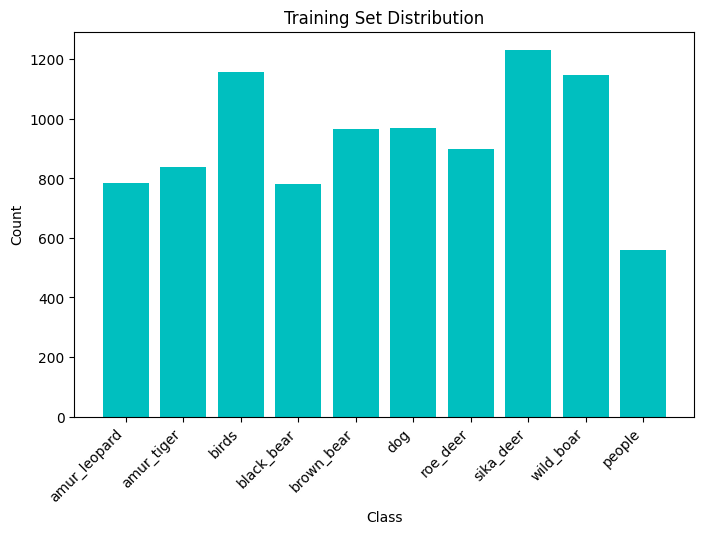

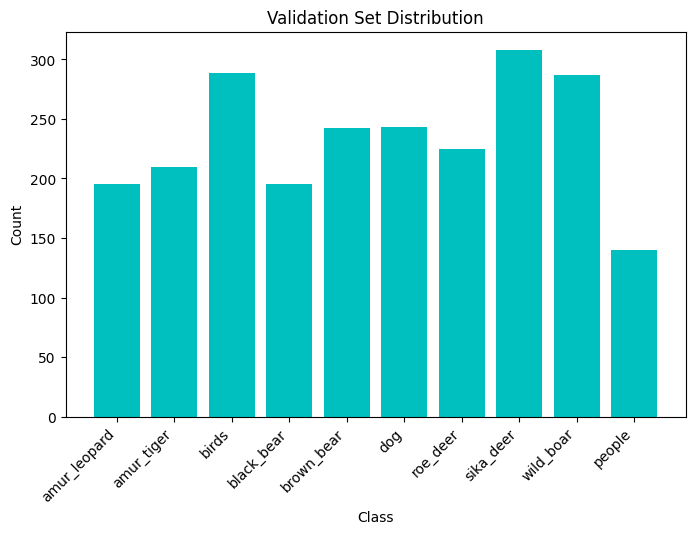

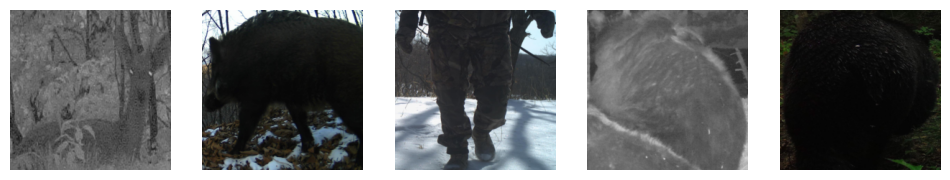

In [2]:
# # Load dataset (CIFAR-10 as an example)
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
from task import train_loader, val_loader

trainloader = train_loader  # Use the custom DataLoader
testloader = val_loader  # Validation set as test set

import matplotlib.pyplot as plt

dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    ax = axes[i]
    img = images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [3]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)  # Fix stride
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate the correct input size for fc1
        self.fc1 = nn.Linear(128 * 14 * 14, 10)  # Fix input features

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)  # Correct flattening
        x = self.fc1(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

KeyboardInterrupt: 

In [ ]:

# Evaluation
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct / total
wandb.log({"Test Accuracy": test_acc})
print(f"Test Accuracy: {test_acc:.2f}%")

# Visualize misclassified images
misclassified = np.where(np.array(all_preds) != np.array(all_labels))[0]
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, idx in enumerate(misclassified[:9]):
    image, label, pred = testset[idx][0], all_labels[idx], all_preds[idx]
    image = image.permute(1, 2, 0).numpy()
    image = (image * 0.5) + 0.5  # Unnormalize
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(f"True: {label}, Pred: {pred}")
    ax.axis('off')

plt.show()
wandb.log({"Misclassified Samples": wandb.Image(fig)})

print("Training complete!")


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def evaluate_and_visualize(model, testloader, testset, device, class_names, num_misclassified=9):
    """
    Evaluates the model on the test set, computes accuracy and F1-score,
    logs a confusion matrix, and visualizes misclassified images.
    """
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy and F1-score
    test_acc = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Test F1-Score: {f1:.4f}")

    # Log results to wandb
    wandb.log({"Test Accuracy": test_acc, "Test F1-Score": f1})

    # Compute and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    wandb.log({"Confusion Matrix": wandb.Image(plt.gcf())})

    # Identify misclassified samples
    misclassified_indices = np.where(np.array(all_preds) != np.array(all_labels))[0]

    if len(misclassified_indices) > 0:
        fig, axes = plt.subplots(3, 3, figsize=(9, 9))
        fig.suptitle("Misclassified Images", fontsize=14)

        for i, idx in enumerate(misclassified_indices[:num_misclassified]):
            image, true_label, pred_label = testset[idx][0], all_labels[idx], all_preds[idx]
            image = image.permute(1, 2, 0).numpy()
            image = (image - image.min()) / (image.max() - image.min())  # Normalize for display

            ax = axes[i // 3, i % 3]
            ax.imshow(image)
            ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
            ax.axis("off")

        plt.show()
        wandb.log({"Misclassified Samples": wandb.Image(fig)})

    print("Evaluation Complete!")

class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

evaluate_and_visualize(model, testloader, testset, device, class_names)